<a href="https://colab.research.google.com/github/JulienGremillot/du_coup/blob/main/du_coup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

J'ai eu des problèmes de compatibilité niveau nombre de channels (mono/stereo), mais surtout au niveau du taux d'échantillonnage. J'arrivais à le corriger avec la librairie librosa, mais pas avec les objets Tensor... Bref, j'ai utilisé la ligne de commande suivante pour corriger mes samples avant les traitements : mkdir du_coup_2; for F in `ls du_coup/*`; do echo $F; F2=`echo $F | cut -d'/' -f2`; sox $F du_coup_2/$F2 remix 1 rate 16000; done

In [ ]:
DATASET_PATH = 'data/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182091776/182082353 [==============================] - 5s 0us/step


In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['left' 'right' 'up' 'no' 'down' 'go' 'yes' 'stop']


In [ ]:
from google.colab import drive
import os
drive.mount("/content/gdrive", force_remount=False)

Mounted at /content/gdrive


In [ ]:
import shutil
src_du_coup = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/du_coup')
dst_du_coup = pathlib.Path(os.path.join(data_dir, 'du_coup'))
if not dst_du_coup.exists():
  print('Copie le répertoire', src_du_coup, 'vers', dst_du_coup)
  shutil.copytree(src_du_coup, dst_du_coup)
else:
  print('Le répertoire', dst_du_coup, 'existe déjà.')

Copie le répertoire /content/gdrive/MyDrive/Colab Notebooks/du_coup vers data/mini_speech_commands/du_coup


In [ ]:
from random import sample
import math

def get_nb_files():
  nb_files = {}
  for command in commands:
    nb_files[command] = len(tf.io.gfile.listdir(str(data_dir/command)))
    print('-', command, ':', nb_files[command])
  return nb_files

pas_du_coup = pathlib.Path(os.path.join(data_dir, 'pas_du_coup'))
nb_du_coup = len(tf.io.gfile.listdir(dst_du_coup))
minimum = math.ceil(nb_du_coup / len(commands))
if not pas_du_coup.exists():
  os.mkdir(pas_du_coup)
for command in commands:
  command_dir = pathlib.Path(os.path.join(data_dir, command))
  if command_dir.exists():
    filenames = tf.io.gfile.listdir(command_dir)
    for file in sample(filenames, len(filenames) - int(minimum)):
      os.remove(os.path.join(data_dir, command, file))
    src_files = os.listdir(command_dir)
    for file in src_files:
        full_file_name = os.path.join(command_dir, file)
        dst_file_name = pathlib.Path(os.path.join(pas_du_coup, file))
        if dst_file_name.exists():
            os.remove(dst_file_name)
        if os.path.isfile(full_file_name):
            shutil.move(full_file_name, pas_du_coup)
    os.rmdir(command_dir)

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Nombre de fichiers par label :')
nb_files = get_nb_files()

Nombre de fichiers par label :
- du_coup : 168
- pas_du_coup : 165


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('\nNombre total de fichiers :', num_samples)


Nombre total de fichiers : 333


In [74]:
filenames.numpy()[0]

b'data/mini_speech_commands/pas_du_coup/c79159aa_nohash_1.wav'

In [ ]:
train_size = round(num_samples * 0.8)
val_size = round(num_samples * 0.1)
test_size = num_samples - train_size - val_size
train_files = filenames[:train_size]
val_files = filenames[train_size: train_size + val_size]
test_files = filenames[-test_size:]

print('Taille du training set :', len(train_files))
print('Taille du validation set :', len(val_files))
print('Taille du test set :', len(test_files))

Taille du training set : 266
Taille du validation set : 33
Taille du test set : 34


In [ ]:
test_file = tf.io.read_file(train_files[0])
print(train_files[0].numpy())
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

b'data/mini_speech_commands/pas_du_coup/c79159aa_nohash_1.wav'


TensorShape([16000, 1])

In [ ]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # la piste est mono, on supprime l'axe `channels`
  #if audio.shape[1] == 1:
  res = tf.squeeze(audio, axis=-1)
  # si la piste est stéréo, on ne conserve que la première piste
  #else:
  #  res = audio[:, 0]
  return res


def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]


def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

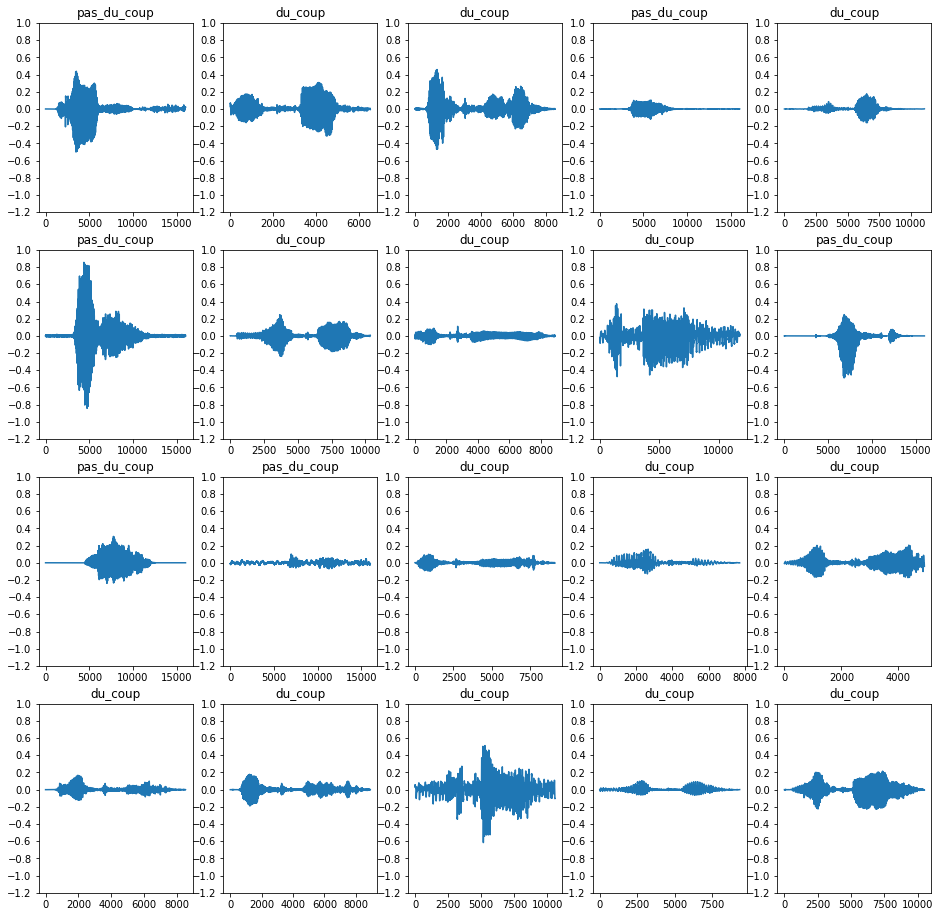

In [ ]:
rows = 4
cols = 5
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 16))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [ ]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
for waveform, label in waveform_ds.take(100):  
  label = label.numpy().decode('utf-8')
  if label == 'du_coup':
    spectrogram = get_spectrogram(waveform)
    break

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: du_coup
Waveform shape: (6511,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

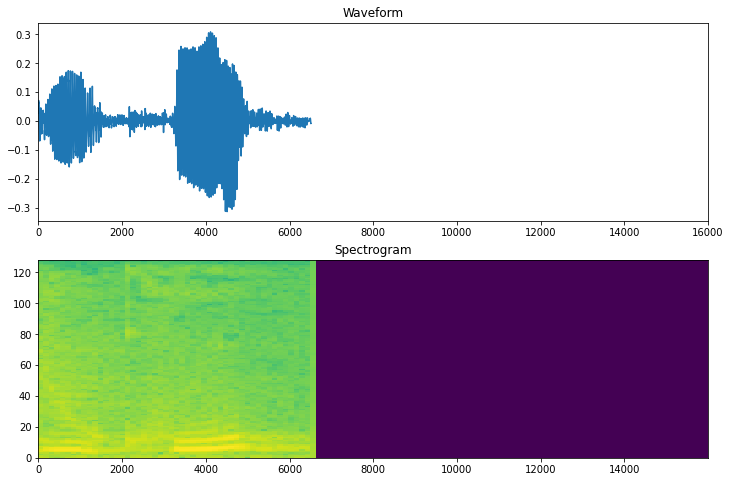

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

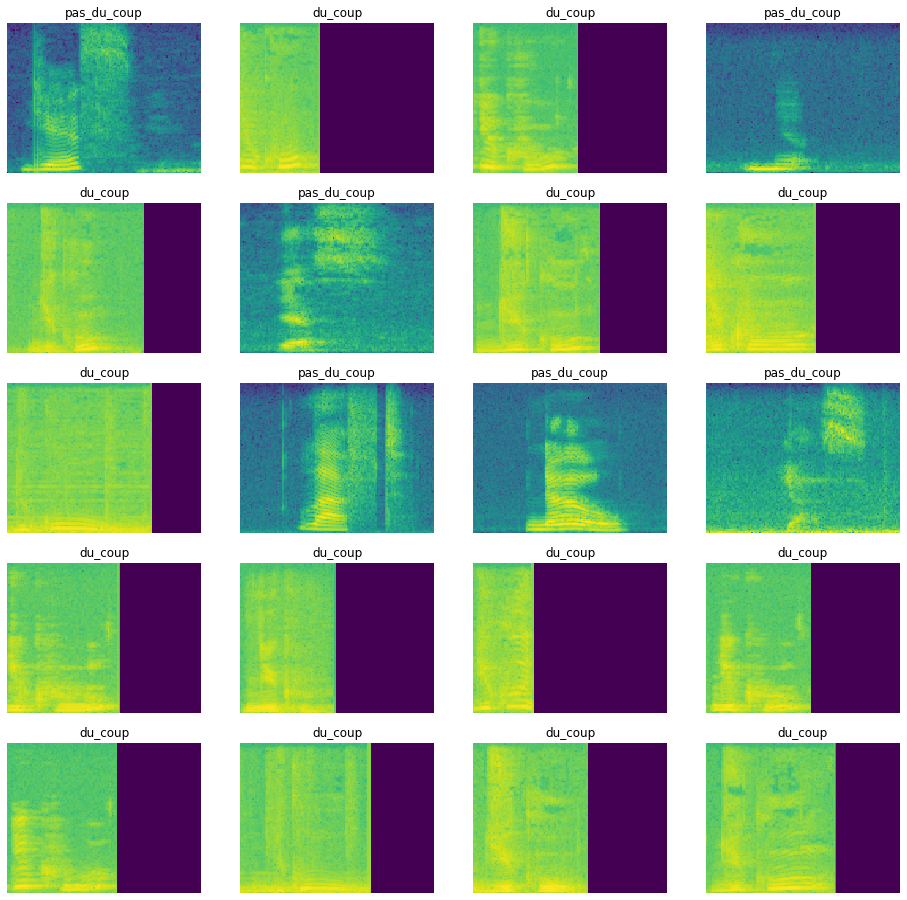

In [ ]:
rows = 5
cols = 4
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 16))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [42]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_2 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)       

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/20
5/5 [==============================] - 3s 341ms/step - loss: 0.4886 - accuracy: 0.7481 - val_loss: 0.3874 - val_accuracy: 0.9091
Epoch 2/20
5/5 [==============================] - 1s 203ms/step - loss: 0.2491 - accuracy: 0.9173 - val_loss: 0.2884 - val_accuracy: 0.9394
Epoch 3/20
5/5 [==============================] - 1s 196ms/step - loss: 0.2002 - accuracy: 0.9361 - val_loss: 0.2380 - val_accuracy: 0.9394
Epoch 4/20
5/5 [==============================] - 1s 192ms/step - loss: 0.1760 - accuracy: 0.9361 - val_loss: 0.1255 - val_accuracy: 0.9697
Epoch 5/20
5/5 [==============================] - 1s 187ms/step - loss: 0.1361 - accuracy: 0.9586 - val_loss: 0.1427 - val_accuracy: 0.9697
Epoch 6/20
5/5 [==============================] - 1s 186ms/step - loss: 0.1027 - accuracy: 0.9624 - val_loss: 0.0648 - val_accuracy: 1.0000
Epoch 7/20
5/5 [==============================] - 1s 195ms/step - loss: 0.0929 - accuracy: 0.9774 - val_loss: 0.0539 - val_accuracy: 1.0000
Epoch 8/20
5/5 [====

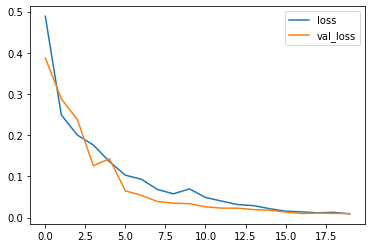

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 100%


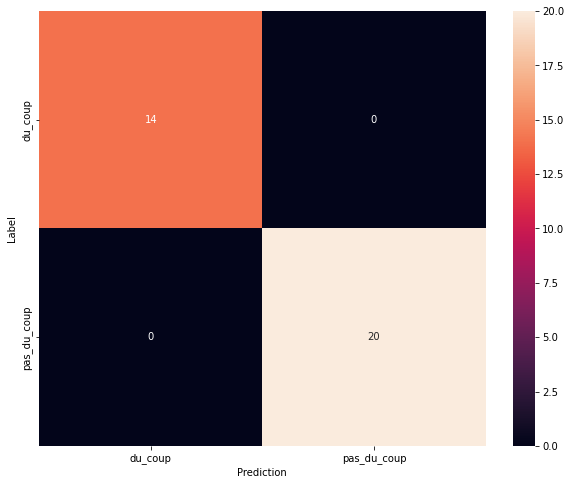

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

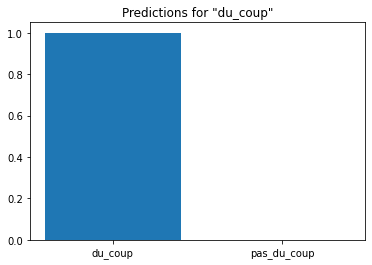

In [ ]:
sample_file = data_dir/'du_coup/du_coup_15.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

In [33]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [34]:
import tensorflow_hub as hub

!pip install tensorflow_io
import tensorflow_io as tfio

     |████████████████████████████████| 23.4 MB 9.4 MB/s 


In [35]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [37]:
saved_model_path = './du_coup_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)

In [43]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_labels)
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [62]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [50]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

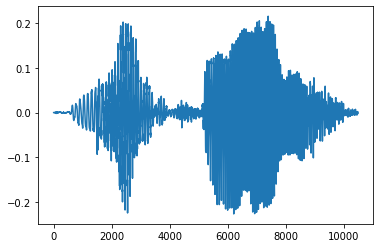

In [68]:
testing_wav_data = load_wav_16k_mono(str(sample_file))

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data,rate=16000)

0

In [120]:
def get_target(file_path):
  if 'pas_du_coup' in str(file_path):
    return np.where(commands=='pas_du_coup')[0][0]
  else:
    return np.where(commands=='du_coup')[0][0]

filenames = train_files.numpy()
targets = [get_target(file_path) for file_path in filenames]
train_ds = tf.data.Dataset.from_tensor_slices((filenames, targets))

filenames = val_files.numpy()
targets = [get_target(file_path) for file_path in filenames]
val_ds = tf.data.Dataset.from_tensor_slices((filenames, targets))
val_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [121]:
def load_wav_for_map(filename, label):
  return load_wav_16k_mono(filename), label

train_ds = train_ds.map(load_wav_for_map)
val_ds = val_ds.map(load_wav_for_map)
train_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [122]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings))

# extract embedding
train_ds = train_ds.map(extract_embedding).unbatch()
val_ds = val_ds.map(extract_embedding).unbatch()
train_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [123]:
train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [124]:
history = my_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callback
)

Epoch 1/20
13/13 [==============================] - 6s 155ms/step - loss: 3.2464 - accuracy: 0.3872 - val_loss: 0.6007 - val_accuracy: 0.6818
Epoch 2/20
13/13 [==============================] - 0s 32ms/step - loss: 0.6098 - accuracy: 0.6872 - val_loss: 0.4849 - val_accuracy: 0.7727
Epoch 3/20
13/13 [==============================] - 0s 35ms/step - loss: 0.4787 - accuracy: 0.7821 - val_loss: 0.4118 - val_accuracy: 0.7955
Epoch 4/20
13/13 [==============================] - 0s 33ms/step - loss: 0.4257 - accuracy: 0.8256 - val_loss: 0.3219 - val_accuracy: 0.8864
Epoch 5/20
13/13 [==============================] - 0s 39ms/step - loss: 0.3704 - accuracy: 0.8333 - val_loss: 0.2978 - val_accuracy: 0.8636
Epoch 6/20
13/13 [==============================] - 0s 36ms/step - loss: 0.3230 - accuracy: 0.8538 - val_loss: 0.2740 - val_accuracy: 0.8409
Epoch 7/20
13/13 [==============================] - 1s 41ms/step - loss: 0.2873 - accuracy: 0.8795 - val_loss: 0.2363 - val_accuracy: 0.8864
Epoch 8/20
1

In [125]:
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./du_coup_yamnet/assets


INFO:tensorflow:Assets written to: ./du_coup_yamnet/assets


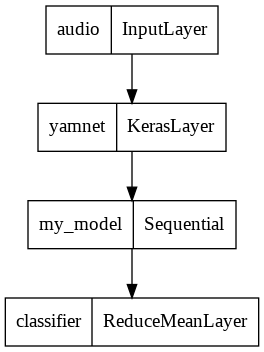

In [126]:
tf.keras.utils.plot_model(serving_model)

In [127]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [128]:
commands

array(['du_coup', 'pas_du_coup'], dtype='<U11')

In [129]:
reloaded_results = reloaded_model(testing_wav_data)
du_coup_or_not = commands[tf.argmax(reloaded_results)]
print(f'The main sound is: {du_coup_or_not}')

The main sound is: du_coup


In [135]:
sample_file_2 = os.listdir(pas_du_coup)[0]
testing_wav_data_2 = load_wav_16k_mono(
    str(os.path.join(pas_du_coup, sample_file_2)))
reloaded_results = reloaded_model(testing_wav_data_2)
du_coup_or_not = commands[tf.argmax(reloaded_results)]
print(f'The main sound is: {du_coup_or_not}')
display.Audio(testing_wav_data_2,rate=16000)

The main sound is: pas_du_coup
